In [1]:
import numpy as np
import scipy as sp
import matplotlib
import itertools
import joblib

import matplotlib.pyplot as plt


from lib.hamiltonian import H_B, H_P, H_D
from lib.time import time, S
from lib import X, D

beta = 0.1
driver = True
alpha_values = np.linspace(0, 1, 300)
N = 7



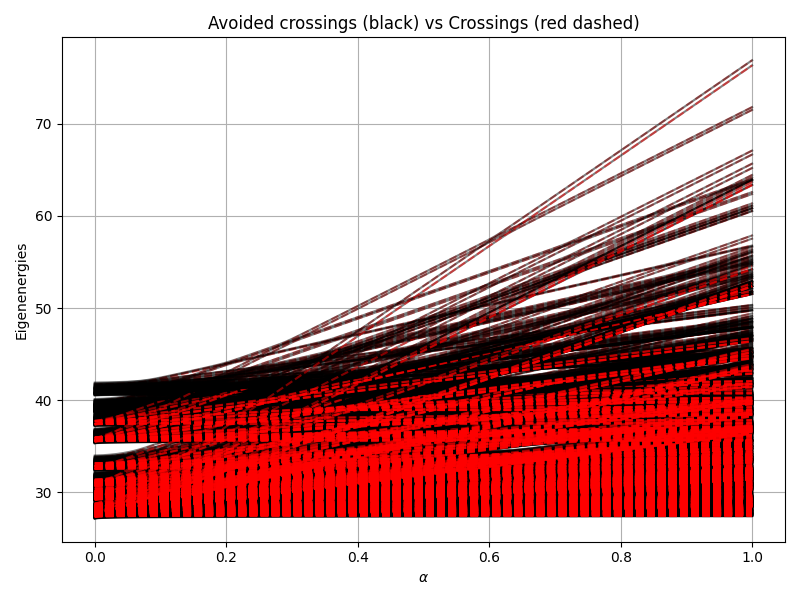

In [2]:
%matplotlib widget
memory = joblib.Memory(location=".joblib_cache", verbose=0)


@memory.cache
def all_move_sequences(N):
    moves = (1, 0, -1)
    return list(itertools.product(moves, repeat=N))


def normalize(vec):
    return vec / np.sum(vec) if np.sum(vec) != 0 else vec


@memory.cache
def Eigenvalues(N, beta, alpha, driver=False, vec_normalize=False):
    eigvals = []
    eigvecs = []
    print(f"Calculating Eigenvalues for N={N}, beta={beta}, driver={driver}")
    for a in alpha:
        print(f"Calculating for alpha={a:2f}", end="\r")
        if driver:
            H = H_B(N) + a*H_P(N) + beta*H_D(N, X)
            vals, vecs = np.linalg.eigh(H)
        else:
            H = H_B(N) + a*H_P(N)
            vals, vecs = np.linalg.eig(H)
        eigvals.append(vals)
        if vec_normalize:
            eigvecs.append(normalize(np.abs(vecs[:, 0])**2))
        else:
            eigvecs.append(vecs)
        del H

    return np.array(eigvals).T, np.array(eigvecs)



hd = H_D(N, X)

eigvals_avoided_crossing, eigvecs = Eigenvalues(
    N=N, beta=beta, alpha=alpha_values, driver=True, vec_normalize=True)
eigvals_crossing, _ = Eigenvalues(
    N=N, beta=beta, alpha=alpha_values, driver=False)
# Plot eigenvalues

plt.figure(figsize=(8, 6))
# for eig_crossing in eigvals_crossing:
for eig_avoided_crossing, eig_crossing in zip(eigvals_avoided_crossing, eigvals_crossing):
    plt.plot(alpha_values, eig_avoided_crossing, color="black", alpha=0.5)
    plt.plot(alpha_values, eig_crossing, color="red",
             alpha=0.5, linestyle="dashed")
plt.xlabel(r"$ \alpha $")
plt.ylabel("Eigenenergies")
plt.grid()
title = "Avoided crossings (black) vs Crossings (red dashed)"
plt.title(title)
plt.tight_layout()
plt.show()

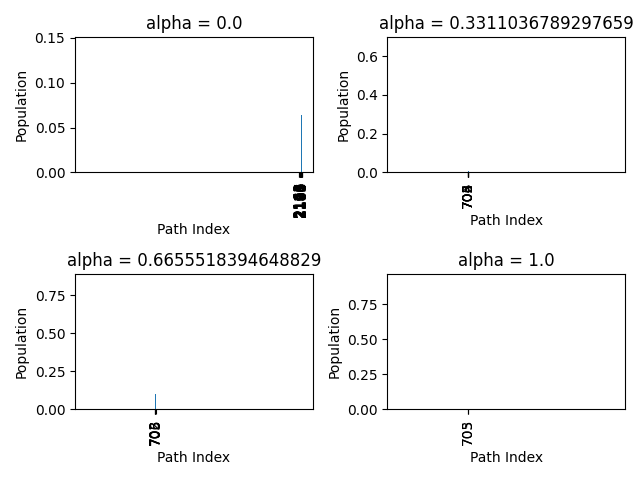

In [3]:
fig, axes = plt.subplots(2, 2)
indices = np.arange(eigvecs.shape[1])
ids = {}

alpha_indices = np.linspace(0, len(alpha_values)-1, 4, dtype=int)
selected_alpha_values = [alpha_values[i] for i in alpha_indices]
selected_eigvecs = [eigvecs[i] for i in alpha_indices]
for i, (alpha_val, eigvec) in enumerate(zip(selected_alpha_values, selected_eigvecs)):
    ax = axes.flat[i]
    ax.bar(indices, eigvec, linewidth=1)
    if i == len(selected_alpha_values) - 1:
        ids[alpha_val] = []
        for j in range(len(eigvec)):
            if eigvec[j] > 10e-3:
                data = {"eigvec": eigvec[j], "path": j, "id": i}
                ids[alpha_val].append(data)
    ax_ids = []
    for j in range(len(eigvec)):
        if eigvec[j] > 10e-3:
            ax_ids.append(j)
    ax.set_title(f"alpha = {alpha_val}")
    ax.set_xlabel("Path Index")
    ax.set_ylabel("Population")
    ax.set_xticks(ax_ids)
    ax.set_xticklabels(ax_ids, rotation=90)

plt.tight_layout()
plt.show()


All possible move sequences for N=7:
For subplot with alpha 1.0:
	Eigenvector: 0.9175358645875643
	Index 703: (1, -1, -1, -1, 1, 1, 0), Time: 27.416251869614747
	Eigenvector: 0.05616813609069625
	Index 705: (1, -1, -1, -1, 1, 0, 1), Time: 27.45411528592912


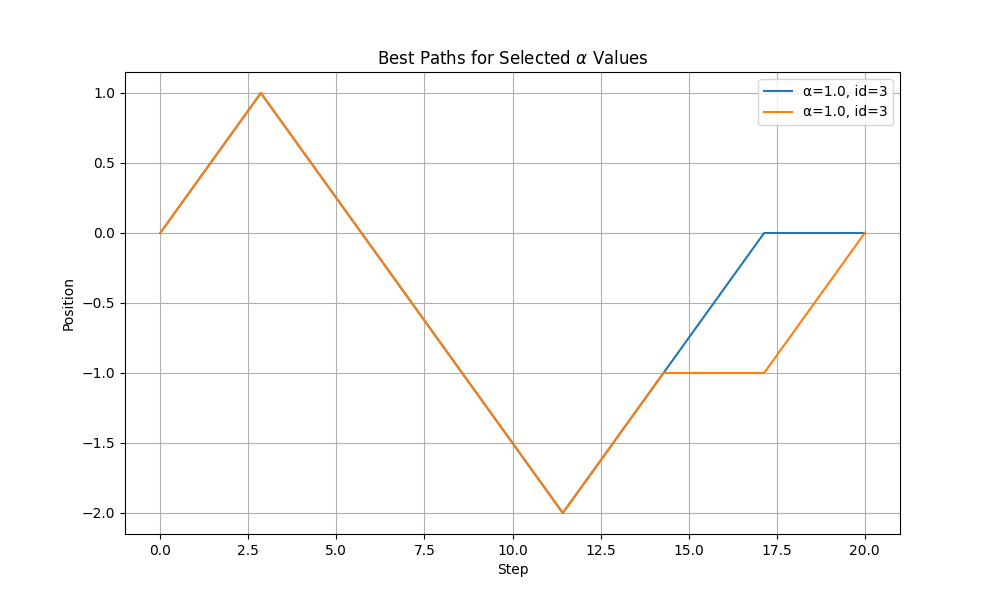

In [4]:

sequences = all_move_sequences(N)
print(f"All possible move sequences for N={N}:")
plt.figure(figsize=(10, 6))
x = np.linspace(0, D, N+1)
for k, v in ids.items():
    print(f"For subplot with alpha {k}:")
    for data in v:
        t = 0
        for i in range(len(sequences[data['path']])):
            t += time(i, sequences[data['path']][i], N)
        path = np.cumsum(sequences[data['path']])
        path = np.insert(path, 0, 0, axis=0)
        print(f"\tEigenvector: {data['eigvec']}")
        print(f"\tIndex {data['path']}: {sequences[data['path']]}, Time: {t}")
        plt.plot(x, path, label=f"α={k}, id={data['id']}")

plt.xlabel("Step")
plt.ylabel("Position")
plt.title(r"Best Paths for Selected $\alpha$ Values")
plt.legend()
plt.grid()
plt.show()